In [1]:
#assigning patients to a "good" or "bad" outcome class and turn this into a classification problem.
import pandas as pd
import os

In [2]:
radiomics_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_Radiomics.csv"
clinical_data_path = "D:\work\ingham-medphys-coding-master\ingham-medphys-coding-master\data\HN_ClinicalData.csv"

In [3]:
#Prepare all the data into the data framework
df_clinical_data=pd.read_csv(clinical_data_path)
df_radiomics=pd.read_csv(radiomics_path)
#attact GTV data
df_gtv_radiomics = df_radiomics[df_radiomics["Structure"].str.startswith("GTV")]
df_gtv_radiomics = df_gtv_radiomics.groupby("id")[["VoxelVolume", "SurfaceArea"]].sum()
#merge data into the clininal data
df = df_clinical_data.merge(df_gtv_radiomics, on="id")

In [4]:
Train_Data=df[df["dataset"]=="train"]
Test_Data=df[df["dataset"]=="test"]

In [5]:
#to transfer the problem into the classification problem (the mean of the overall_survival_in_days is near 5 years)
#overall_survival_data>1825 is good, otherwise is bad
import numpy as np
np.mean(df["overall_survival_in_days"])
for i, row in df.iterrows():
    if df.at[i,'overall_survival_in_days']>1825:
        df.at[i,'overall_survival_in_days'] = 1
    else: 
        df.at[i,'overall_survival_in_days'] = 0

In [6]:
Train_Data=df[df["dataset"]=="train"]
Test_Data=df[df["dataset"]=="test"]

In [7]:
Test_Data['overall_survival_in_days'].head()

1     1
13    0
16    1
21    1
22    0
Name: overall_survival_in_days, dtype: int64

In [9]:
#Data cleaning, fill null, delete null and object data to int
df_Train_Data = Train_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Test_Data = Test_Data.drop(['overall_hpv_p16_status', 'pretreat_hb_in_mmolperlitre'],axis=1)
df_Train_Data['performance_status_ecog'].fillna(df_Train_Data['performance_status_ecog'].value_counts().index[0], inplace=True)
df_Test_Data['performance_status_ecog'].fillna(df_Test_Data['performance_status_ecog'].value_counts().index[0], inplace=True)
df_train=df_Train_Data
df_test=df_Test_Data

In [10]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
cols = ('index_tumour_location', 'biological_sex', 'ajcc_stage', 'cancer_surgery_performed', 'chemotherapy_given')
# process columns, apply LabelEncoder to categorical features into numeric data
for c in cols:
    df_train[c] = labelencoder.fit_transform(df_train[c])
    df_test[c] = labelencoder.fit_transform(df_test[c])

In [11]:
x_train = df_train.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_train = df_train["overall_survival_in_days"]
x = x_train.values
y = Y_train.values

In [12]:
x_test = df_test.drop(['id', 'dataset', 'overall_survival_in_days'], axis=1)
Y_test = df_test["overall_survival_in_days"]
inputx = x_test.values
outputy = Y_test.values

In [13]:
#modeling
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [14]:
def classification_model(model, data, x_train, Y_train):
  #Fit the model:
  model.fit(x_train,Y_train)
  
  #Make predictions on training set:
  predictions = model.predict(x_train)
  
  #Print accuracy
  accuracy = accuracy_score(predictions,Y_train)
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(n_splits=5).split(data)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (x_train.iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = Y_train.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(x_train.iloc[test,:], Y_train.iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(x_train,Y_train) 

In [15]:
logmodel=LogisticRegression()
classification_model(logmodel,df_train,x_train,Y_train)
predictions = logmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 97.059%
Cross-Validation Score : 80.952%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.476%
Cross-Validation Score : 87.857%
Cross-Validation Score : 88.286%
Accuracy : 77.143%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [16]:
ranmodel = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(ranmodel,df_train,x_train,Y_train)
predictions = ranmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 94.118%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 88.286%
Accuracy : 77.143%


In [17]:
decmodel = DecisionTreeClassifier()
classification_model(decmodel,df_train,x_train,Y_train)
predictions = decmodel.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 83.333%
Cross-Validation Score : 87.222%
Cross-Validation Score : 87.917%
Cross-Validation Score : 87.333%
Accuracy : 77.143%


In [18]:
clf = lgb.LGBMClassifier()
classification_model(clf,df_train,x_train,Y_train)
predictions = clf.predict(x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 89.286%
Accuracy : 80.000%


In [19]:
#improve the results with fewer features
cols = list(x_train.columns)
featimp = pd.Series(ranmodel.feature_importances_,index = cols).sort_values(ascending=False)
print(featimp)

distant_metastases_in_days                        0.135343
local_recurrence_in_days                          0.130342
recurrence_metastatic_free_survival_in_days       0.126793
locoregional_recurrence_in_days                   0.120530
event_overall_survival                            0.100162
SurfaceArea                                       0.053176
VoxelVolume                                       0.042409
age_at_diagnosis                                  0.040042
event_recurrence_metastatic_free_survival         0.038594
clin_n                                            0.030183
ajcc_stage                                        0.027541
radiotherapy_number_fractions_highriskgtv         0.025625
event_locoregional_recurrence                     0.021567
event_local_recurrence                            0.018128
radiotherapy_total_treat_time                     0.017735
radiotherapy_refgydose_total_highriskgtv          0.015947
clin_t                                            0.0144

In [20]:
x_train=df_train[featimp[:10].index]
x_test=df_test[featimp[:10].index]
x_train.info()
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 136
Data columns (total 10 columns):
distant_metastases_in_days                     102 non-null int64
local_recurrence_in_days                       102 non-null int64
recurrence_metastatic_free_survival_in_days    102 non-null int64
locoregional_recurrence_in_days                102 non-null int64
event_overall_survival                         102 non-null int64
SurfaceArea                                    102 non-null float64
VoxelVolume                                    102 non-null float64
age_at_diagnosis                               102 non-null int64
event_recurrence_metastatic_free_survival      102 non-null int64
clin_n                                         102 non-null int64
dtypes: float64(2), int64(8)
memory usage: 8.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1 to 133
Data columns (total 10 columns):
distant_metastases_in_days                     35 non-null int64
local_recurr

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)
scaled_x_train = pd.DataFrame(X_train , index=x_train.index, columns=x_train.columns)
scaled_x_test = pd.DataFrame(X_test , index=x_test.index, columns=x_test.columns)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [22]:
ranmodel = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(ranmodel,df_train,scaled_x_train,Y_train)
predictions = ranmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 92.157%
Cross-Validation Score : 80.952%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 88.286%
Accuracy : 80.000%


In [23]:
clf = lgb.LGBMClassifier()
classification_model(clf,df_train,scaled_x_train,Y_train)
predictions = clf.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 85.714%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.810%
Cross-Validation Score : 90.357%
Cross-Validation Score : 89.286%
Accuracy : 85.714%


In [24]:
decmodel = DecisionTreeClassifier()
classification_model(decmodel,df_train,scaled_x_train,Y_train)
predictions = decmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 100.000%
Cross-Validation Score : 90.476%
Cross-Validation Score : 90.476%
Cross-Validation Score : 90.317%
Cross-Validation Score : 90.238%
Cross-Validation Score : 88.190%
Accuracy : 80.000%


In [25]:
logmodel=LogisticRegression(random_state = 42,max_iter= 150)
classification_model(logmodel,df_train,scaled_x_train,Y_train)
predictions = logmodel.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 94.118%
Cross-Validation Score : 85.714%
Cross-Validation Score : 90.476%
Cross-Validation Score : 90.317%
Cross-Validation Score : 92.738%
Cross-Validation Score : 92.190%
Accuracy : 91.429%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [26]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics# add validation dataset

Using TensorFlow backend.


In [27]:
classifier = models.Sequential()
#add input layer and first hidden layer
classifier.add(layers.Dense(output_dim = 6, kernel_initializer = "uniform", activation = "relu", input_dim = 10))
#add 2nd hidden layer
classifier.add(layers.Dense(output_dim = 6, kernel_initializer = "uniform", activation = "relu"))
classifier.add(layers.Dense(output_dim = 1, kernel_initializer = "uniform", activation = "sigmoid"))
classifier.compile(optimizer = "Adam", loss ="binary_crossentropy", metrics = ["accuracy"])

d:\app\python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", input_dim=10, units=6)`
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Colocations handled automatically by placer.


d:\app\python\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="relu", units=6)`
  """
d:\app\python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="uniform", activation="sigmoid", units=1)`
  


In [28]:
#classifier.fit(scaled_x_train,Y_train, batch_size = 10, epochs = 100)

classifier.fit(scaled_x_train, Y_train, batch_size = 10, epochs = 100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
102/102 [==============================] - 2s 20ms/step - loss: 0.6930 - acc: 0.5196
Epoch 2/100
102/102 [==============================] - 0s 108us/step - loss: 0.6922 - acc: 0.5784
Epoch 3/100
102/102 [==============================] - 0s 127us/step - loss: 0.6912 - acc: 0.5784
Epoch 4/100
102/102 [==============================] - 0s 127us/step - loss: 0.6890 - acc: 0.5784
Epoch 5/100
102/102 [==============================] - 0s 136us/step - loss: 0.6856 - acc: 0.5784
Epoch 6/100
102/102 [==============================] - 0s 137us/step - loss: 0.6802 - acc: 0.5784
Epoch 7/100
102/102 [==============================] - 0s 118us/step - loss: 0.6718 - acc: 0.5784
Epoch 8/100
102/102 [==============================] - 0s 98us/step - loss: 0.6605 - acc: 0.5784
Epoch 9/100
102/102 [==============================] - 0s 127us/step - loss: 0.6443 - acc: 0.6471
Epoch 10/100
102/102 [==============================] - 0s 137us/step - 

102/102 [==============================] - 0s 137us/step - loss: 0.1259 - acc: 0.9510
Epoch 81/100
102/102 [==============================] - 0s 117us/step - loss: 0.1248 - acc: 0.9510
Epoch 82/100
102/102 [==============================] - 0s 98us/step - loss: 0.1238 - acc: 0.9510
Epoch 83/100
102/102 [==============================] - 0s 117us/step - loss: 0.1229 - acc: 0.9510
Epoch 84/100
102/102 [==============================] - 0s 98us/step - loss: 0.1221 - acc: 0.9510
Epoch 85/100
102/102 [==============================] - 0s 88us/step - loss: 0.1213 - acc: 0.9510
Epoch 86/100
102/102 [==============================] - 0s 98us/step - loss: 0.1205 - acc: 0.9510
Epoch 87/100
102/102 [==============================] - 0s 98us/step - loss: 0.1198 - acc: 0.9510
Epoch 88/100
102/102 [==============================] - 0s 88us/step - loss: 0.1189 - acc: 0.9510
Epoch 89/100
102/102 [==============================] - 0s 98us/step - loss: 0.1181 - acc: 0.9510
Epoch 90/100
102/102 [========

In [29]:
predictions = classifier.predict(scaled_x_test)
new_prediction = (predictions > 0.5)
accuracy = accuracy_score(new_prediction,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 88.571%


In [30]:
from sklearn import svm

In [31]:
svmr= svm.SVC(kernel='rbf')
classification_model(svmr,df_train,scaled_x_train,Y_train)
predictions = svmr.predict(scaled_x_test)
accuracy = accuracy_score(predictions,Y_test)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 94.118%
Cross-Validation Score : 85.714%
Cross-Validation Score : 88.095%
Cross-Validation Score : 90.397%
Cross-Validation Score : 92.798%
Cross-Validation Score : 92.238%
Accuracy : 88.571%


d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change f

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(logmodel.predict(scaled_x_test), Y_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 9  2]
 [ 1 23]]

True Positives(TP) =  9

True Negatives(TN) =  23

False Positives(FP) =  2

False Negatives(FN) =  1


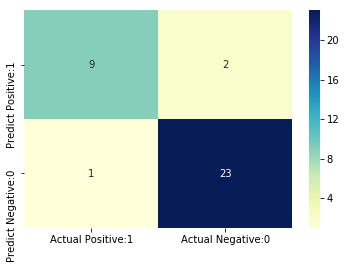

In [33]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [34]:
x_train_re =df_train.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
x_test_re =df_test.drop(['id', 'dataset', 'overall_survival_in_days','recurrence_metastatic_free_survival_in_days'], axis=1)
Y_train_re = df_train["recurrence_metastatic_free_survival_in_days"]
Y_test_re = df_test["recurrence_metastatic_free_survival_in_days"]
Y_train_re = (Y_train_re > 1825)
Y_test_re = (Y_test_re > 1825)
X_train_re = sc.fit_transform(x_train_re)
X_test_re= sc.transform(x_test_re)
scaled_x_train_re = pd.DataFrame(X_train_re , index=x_train_re.index, columns=x_train_re.columns)
scaled_x_test_re = pd.DataFrame(X_test_re , index=x_test_re.index, columns=x_test_re.columns)

d:\app\python\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\app\python\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\app\python\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [35]:
logmodel=LogisticRegression(random_state = 42,max_iter= 150)
classification_model(logmodel,df_train,scaled_x_train_re,Y_train_re)
predictions = logmodel.predict(scaled_x_test_re)
accuracy = accuracy_score(predictions,Y_test_re)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 98.039%
Cross-Validation Score : 95.238%
Cross-Validation Score : 92.857%
Cross-Validation Score : 90.238%
Cross-Validation Score : 91.429%
Cross-Validation Score : 92.143%
Accuracy : 88.571%


d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\app\python\lib\site-pa

In [36]:
svmr= svm.SVC(kernel='rbf')
classification_model(svmr,df_train,scaled_x_train_re,Y_train_re)
predictions = svmr.predict(scaled_x_test_re)
accuracy = accuracy_score(predictions,Y_test_re)
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 98.039%
Cross-Validation Score : 95.238%
Cross-Validation Score : 95.238%
Cross-Validation Score : 93.492%
Cross-Validation Score : 93.869%
Cross-Validation Score : 94.095%
Accuracy : 85.714%


d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
d:\app\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change f

In [37]:
cm = confusion_matrix(logmodel.predict(scaled_x_test_re), Y_test_re)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[21  1]
 [ 3 10]]

True Positives(TP) =  21

True Negatives(TN) =  10

False Positives(FP) =  1

False Negatives(FN) =  3


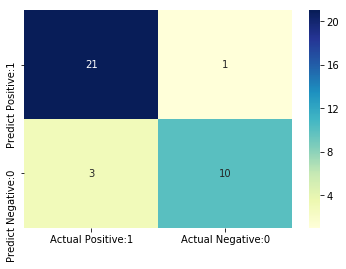

In [38]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')